In [7]:
import time
import datetime
import Hazard
from Utils.NetworkUtils import *
from Utils.Plot import *
from DynamicNetwork import DynamicNetwork
from HazardMLE import *

# Used to generate dynamic network
start_date = int(time.mktime(datetime.datetime.strptime("08/16/2016", "%m/%d/%Y").timetuple()))
file = "network_data/TheGoodPlace_sample.graphml"   # The good place network
WEEK_IN_SECOND = 7 * 24 * 60 * 60                   # Week in second
HAZARD_BETA = [0.01, 0.3, 0.3]

g = get_graphml(file)
g = sample(g, 200/len(g))      # Get a small sample of network (200 nodes)   
graph_info(g)

Graph nodes: 2962, edges: 10595
Remove 2271 self loops.
Graph nodes: 2962, edges: 8324
Graph nodes: 200, edges: 28


In [8]:
g = DynamicNetwork(g)   
# Hazard model simulation, using params [beta1, beta2, beta3] = [0.01, 0.3 ,0.3]
model = Hazard.Hazard(g, start_date, WEEK_IN_SECOND, HAZARD_BETA)        
ref_result, fake_data = model.hazard()
print("Adopted users every week: {}, {} steps.".format(ref_result, len(ref_result)))

Node 2769085730, neighobrs [] adopted neighbors 0 Not Adopted
Node 2769085730 week 1471330800 adopted neighbors 0 Adoption Possibility 0.47289, got 0.65889, Not Adopted
Node 284145743, neighobrs [] adopted neighbors 0 Not Adopted
Node 284145743 week 1471330800 adopted neighbors 0 Adoption Possibility 0.61987, got 0.88468, Not Adopted
Node 22584243, neighobrs ['216937659'] adopted neighbors 0 Adopted
Node 22584243 Week 1471330800, adopted neighbors 0 Adoption Possibility 0.52743, got 0.10051, Adopted
Node 4534502175, neighobrs [] adopted neighbors 0 Not Adopted
Node 4534502175 week 1471330800 adopted neighbors 0 Adoption Possibility 0.41832, got 0.99778, Not Adopted
Node 402019032, neighobrs [] adopted neighbors 0 Not Adopted
Node 402019032 week 1471330800 adopted neighbors 0 Adoption Possibility 0.58749, got 0.95995, Not Adopted
Node 91166552, neighobrs [] adopted neighbors 0 Adopted
Node 91166552 Week 1471330800, adopted neighbors 0 Adoption Possibility 0.59969, got 0.39671, Adopted
N

In [9]:
def fake_train_data(fake_data):
    from pandas import DataFrame, Series
    train_data_exog = []
    train_data_endog = []
    
    # For demo only begin
    for k, i in fake_data.items():
        train_data_exog.append([k[0], k[1]] + [1] + list(i[1:]) + [i[0]])
        train_data_endog.append(i[0])
    train_data_exog.sort(key=lambda i: (i[0], i[1]))
    train_data_exog = DataFrame(
        train_data_exog, 
        columns=["NODEID", "SECONDS", "CONSTANT", "ADOPTED_NEIGHBORS", "SENTIMENT", "ADOPTION"])
    print(train_data_exog.head())
    # For demo only end
    #
    
    train_data_exog = []
    train_data_endog = []
    for k, i in fake_data.items():
        train_data_exog.append([1] + list(i[1:]))
        train_data_endog.append(i[0])
    train_data_exog = DataFrame(train_data_exog, columns=["CONSTANT", "ADOPTED_NEIGHBORS", "SENTIMENT"])
    train_data_endog = Series(train_data_endog, name="ADOPTION")

    return train_data_exog, train_data_endog

# Get exog and endog for mle
exog, endog = fake_train_data(fake_data)

       NODEID     SECONDS  CONSTANT  ADOPTED_NEIGHBORS  SENTIMENT  ADOPTION
0   100076904  1471330800         1                  0   0.623886         0
1   100076904  1471935600         1                  0   0.649590         1
2  1064250919  1471330800         1                  0   0.777372         1
3  1071081744  1471330800         1                  0  -0.432655         1
4  1098478994  1471330800         1                  0   0.051108         1


In [10]:
result = HazardModel(exog=exog, endog=endog).fit()
print("Beta values {}".format(result.params))

Optimization terminated successfully.
         Current function value: 0.682661
         Iterations: 87
         Function evaluations: 150


Beta values [ 0.06758609  0.71852406  0.22330189]


In [11]:
def print_loglikelihood(exogs, endogs, params):
    exogs = np.asarray(exogs)
    endogs = np.asarray(endogs)

    log_likelihood = 0

    for exog, endog in zip(exogs, endogs):
        if endog == 1:
            log_likelihood += stats.norm.logcdf(np.dot(exog, params)).sum()
        elif endog == 0:
            log_likelihood += stats.norm.logcdf(-1 * np.dot(exog, params)).sum()
        else:
            assert False, "Shouldn't run into this line"

    print("{}, {}".format(params, log_likelihood))
    
# params = [round(p, 3) for p in result.params] # Reset params to 3 digits after decimal
print("MLE loglikelihood")
print_loglikelihood(exog, endog, result.params)
print("Original loglikelihood")
print_loglikelihood(exog, endog, HAZARD_BETA)

MLE loglikelihood
[ 0.06758609  0.71852406  0.22330189], -255.3151130049772
Original loglikelihood
[0.01, 0.3, 0.3], -256.46662321945774


Node 2769085730, neighobrs [] adopted neighbors 0 Adopted
Node 2769085730 Week 1471330800, adopted neighbors 0 Adoption Possibility 0.59686, got 0.40226, Adopted
Node 284145743, neighobrs [] adopted neighbors 0 Adopted
Node 284145743 Week 1471330800, adopted neighbors 0 Adoption Possibility 0.60517, got 0.05430, Adopted
Node 22584243, neighobrs ['216937659'] adopted neighbors 0 Not Adopted
Node 22584243 week 1471330800 adopted neighbors 0 Adoption Possibility 0.61413, got 0.80743, Not Adopted
Node 4534502175, neighobrs [] adopted neighbors 0 Not Adopted
Node 4534502175 week 1471330800 adopted neighbors 0 Adoption Possibility 0.50919, got 0.54093, Not Adopted
Node 402019032, neighobrs [] adopted neighbors 0 Not Adopted
Node 402019032 week 1471330800 adopted neighbors 0 Adoption Possibility 0.43830, got 0.81734, Not Adopted
Node 91166552, neighobrs [] adopted neighbors 0 Adopted
Node 91166552 Week 1471330800, adopted neighbors 0 Adoption Possibility 0.57813, got 0.56013, Adopted
Node 300

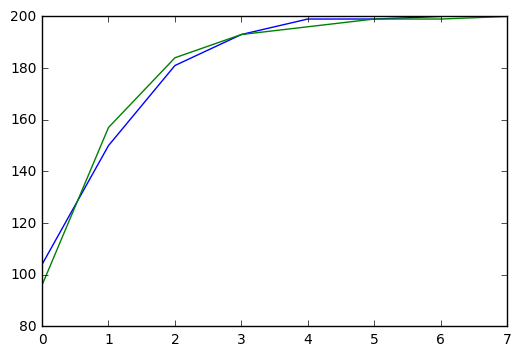

In [12]:
sim_model = Hazard.Hazard(g, start_date, WEEK_IN_SECOND, result.params)
sim_result, _ = sim_model.hazard()
plot([ref_result, sim_result])